#### Notebook 2

- Monthly and seasonal verification of model simulations

In [11]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import rioxarray
import cartopy
import pyproj
import numpy as np
import xskillscore
import matplotlib.pyplot as plt

import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Variable options

var_type:
- single or pressure

var:
- single: t2m, prec
- pressure: t, relhum, geopotential

level:
- 925, 850

In [19]:
var_type = 'single'
var = 'prec'
level = False
start_date = '2008-06-01'
end_date = '2009-02-28'
agg_by = 'sum' # aggregation type 
agg_for = '1M' # aggregate for

Retrieve aggregated ERA5 and model files

In [20]:
da_model, da_era = util.get_model_era_files(var_type=var_type, var=var, level=level,
                                            start_date=start_date, end_date=end_date,)

Regrid and interpolate ERA5 data to the model grid

In [21]:
# regrid
model_proj = util.ModelProj().crs_info_model # crs info for the model
era_proj = 4326 # input esg code for era

da_model, da_era = util.regrid_match(da_model, da_era,
                                     model_proj, era_proj)

In [22]:
# interpolate
rlat, rlon, time = da_model.indexes.values()
da_era = da_era.interp(rlon=rlon, rlat=rlat, method="nearest") # interp to model grid

In [23]:
if var=="prec":
    da_era = da_era*1000 # m to mm

##### Monthly Verification

In [24]:
da_model_aggr = util.aggregate_file(da_model, agg_by, agg_for)
da_era_aggr = util.aggregate_file(da_era, agg_by, agg_for)

In [32]:
da_monthly_verif.min()

<xarray.DataArray ()>
array(-438.01538086)
Coordinates:
    rotated_pole  int64 0
    spatial_ref   int64 0

In [29]:
da_monthly_verif = (da_model_aggr - da_era_aggr)

In [9]:
da_monthly_verif.time

<xarray.DataArray 'time' (time: 9)>
array(['2008-06-30T00:00:00.000000000', '2008-07-31T00:00:00.000000000',
       '2008-08-31T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-10-31T00:00:00.000000000', '2008-11-30T00:00:00.000000000',
       '2008-12-31T00:00:00.000000000', '2009-01-31T00:00:00.000000000',
       '2009-02-28T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 2008-06-30 2008-07-31 ... 2009-02-28
    rotated_pole  int64 0
    spatial_ref   int64 0

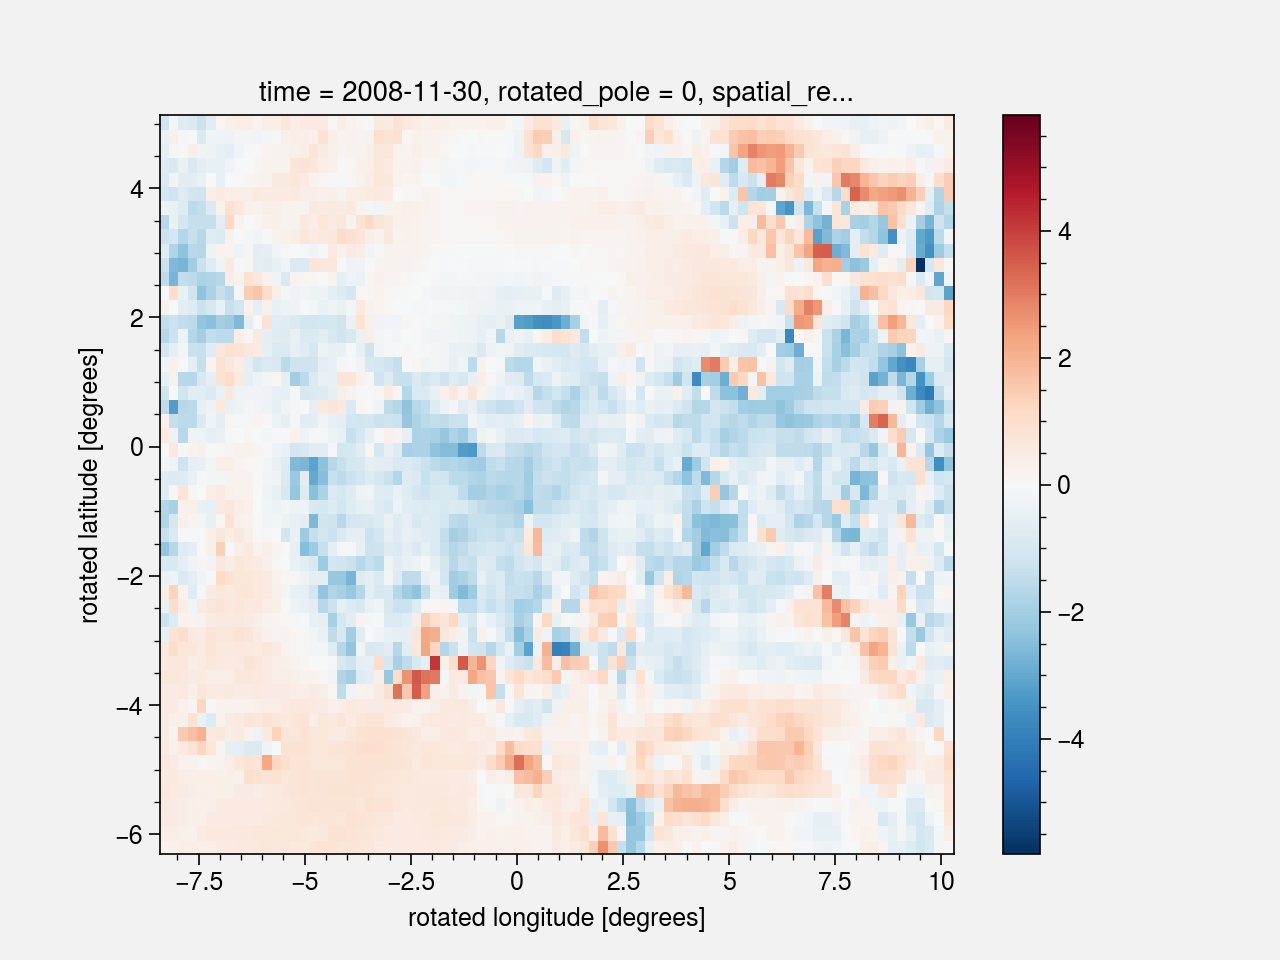

In [10]:
da_monthly_verif.isel(time=5).plot()

Save the prepared verification file

In [129]:
prepath = 'data/post_processed/'
util.save_verif_file(da=da_monthly_verif, var=var, level=level,
                     prepath=prepath, verif_type='monthly')

'model_t_850_monthly_verif.nc created'

##### Seasonal Verification

- Seasonal mean of monthly values

In [130]:
da_model_aggr = util.aggregate_file(da_model, agg_by, agg_for)
da_era_aggr = util.aggregate_file(da_era, agg_by, agg_for)

In [131]:
da_model_seasonal = da_model_aggr.groupby("time.season").mean(dim="time")
da_era_seasonal = da_era_aggr.groupby("time.season").mean(dim="time")

In [132]:
da_model_seasonal.season.values

array(['DJF', 'JJA', 'SON'], dtype=object)

In [133]:
da_seasonal_verif = (da_model_seasonal - da_era_seasonal)

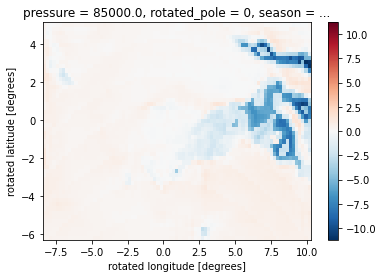

In [134]:
da_seasonal_verif.sel(season="DJF").plot()

Save the prepared verification file

In [135]:
prepath = 'data/post_processed/'
util.save_verif_file(da=da_seasonal_verif, var=var, level=level,
                     prepath=prepath, verif_type='seasonal')

'model_t_850_seasonal_verif.nc created'

##### Scores

- Calculate Correlation, RMSE and MAE verifications between the model and ERA5 using the aggregated data

In [170]:
ds_rmse = xskillscore.rmse(da_model_aggr, da_era_aggr, dim='time')
ds_mae = xskillscore.mae(da_model_aggr, da_era_aggr, dim='time')
ds_corr = xskillscore.pearson_r(da_model_aggr, da_era_aggr, dim='time')

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: divide by zero encountered in true_divide
  r = r_num / r_den


In [171]:
ds_rmse.name = "rmse"
ds_mae.name = "mae"
ds_corr.name = "corr"

In [172]:
# merge scores in a single dataset
merged_scores = xr.merge([ds_rmse, ds_mae, ds_corr])

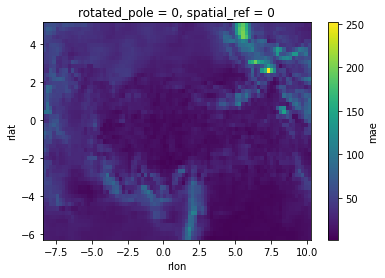

In [174]:
merged_scores['mae'].plot()

In [175]:
prepath = 'data/post_processed/'
util.save_score_file(ds=merged_scores, var=var, 
                     level=level, prepath=prepath, )

'model_prec_scores.nc created'